In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2

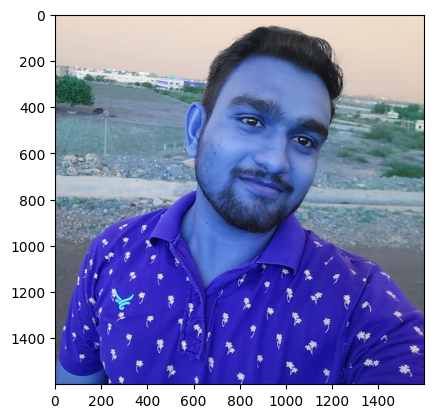

In [2]:
img = cv2.imread('./me.jpg')
plt.imshow(img)

In [3]:
img.shape

(1600, 1600, 3)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [5]:
gray.shape

(1600, 1600)

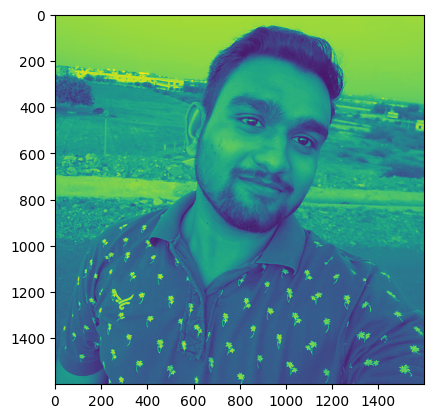

In [6]:
plt.imshow(gray)

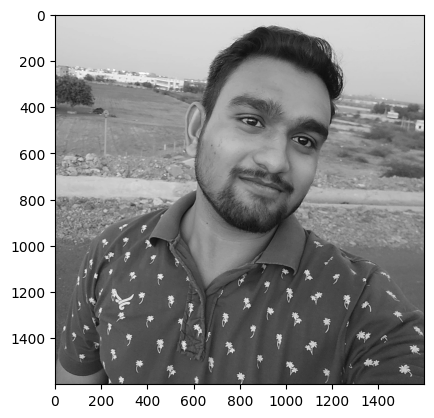

In [7]:
plt.imshow(gray, cmap='gray')

In [8]:
# DETECT EYES AND FACE TO CROP IT

In [8]:
face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(gray,1.3,)
faces

array([[587, 206, 727, 727]], dtype=int32)

In [9]:
x,y,w,h = faces[0]
x,y,w,h

(np.int32(587), np.int32(206), np.int32(727), np.int32(727))

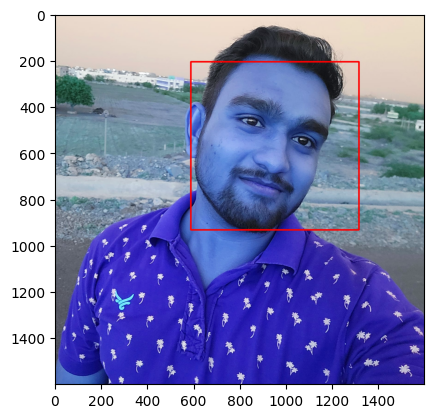

In [10]:
face_img = cv2.rectangle(img, (x, y), (x+w, y+h), (255,0,0), 5)
plt.imshow(face_img)

In [11]:
cv2.destroyAllWindows()

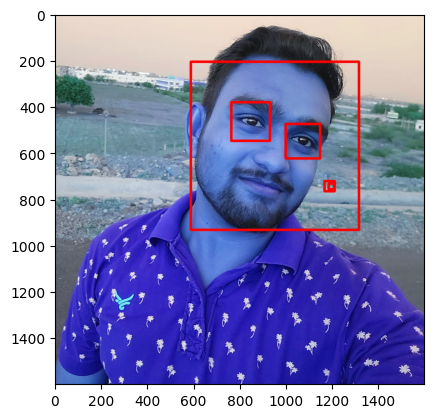

In [12]:
for x,y,w,h in faces:
    face_img = cv2.rectangle(img, (x, y), (x+w, y+h),(255,0,0), 10)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for ex, ey,ew,eh in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ ew, ey+eh), (255, 0, 0), 10)

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

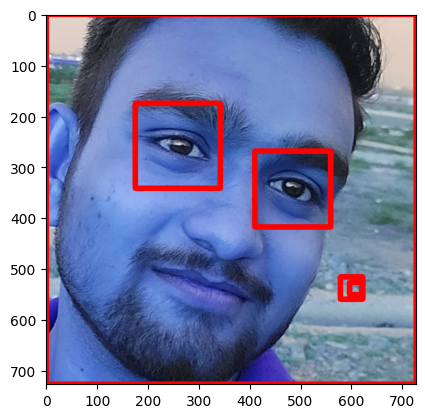

In [13]:
plt.imshow(roi_color, cmap='gray')

In [14]:
crop_img = np.array(roi_color)
crop_img.shape

(727, 727, 3)

In [16]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imgArr = img
    #Datatype conversions
    #convert to grayscale
    imgArr = cv2.cvtColor( imgArr,cv2.COLOR_RGB2GRAY )
    #convert to float
    imgArr =  np.float32(imgArr)   
    imgArr /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imgArr, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imgArr_h=pywt.waverec2(coeffs_H, mode);
    imgArr_h *= 255;
    imgArr_h =  np.uint8(imgArr-h)

    return imgArr_h

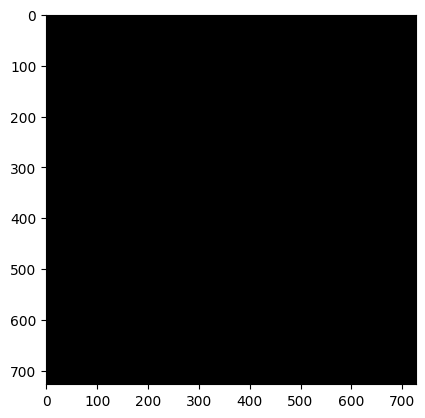

In [17]:
im_har = w2d(crop_img,'db1', 5)
plt.imshow(im_har, cmap='gray')

In [18]:
def get_cropped_image_if_2_eyes(image_path):
    img1 = cv2.imread(image_path)
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    faces1 = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces1:
        roi_gray1 = gray1[y:y+h, x:x+w]
        roi_color1 = img1[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray1)
        if len(eyes) >= 2:
            return roi_color1

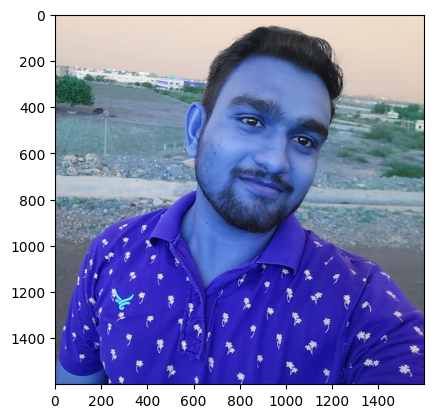

In [19]:
original_image = cv2.imread('./me.jpg')
plt.imshow(original_image)

In [20]:
# cropped_image = get_cropped_image_if_2_eyes('D:/Me/sd.jpg')
# plt.imshow(cropped_image)

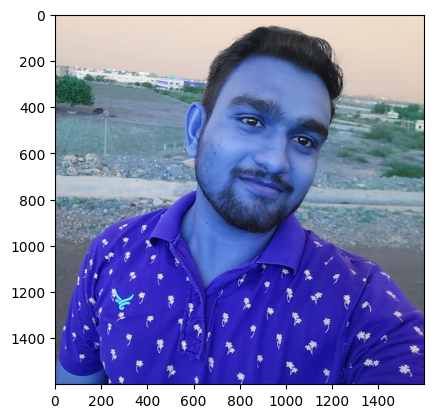

In [22]:
org_image_obstructed = cv2.imread('./me.jpg')
plt.imshow(org_image_obstructed)

In [23]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./me.jpg')
cropped_image_no_2_eyes

In [26]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [49]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

6


In [50]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [51]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name1 = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name1] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name1
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name1 + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name1].append(cropped_file_path)
            count += 1


1


In [52]:

celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name1 = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name1] = file_list
celebrity_file_names_dict

{}

In [53]:
class_dict = {}
count = 0
for celebrity_name1 in celebrity_file_names_dict.keys():
    class_dict[celebrity_name1] = count
    count = count + 1
class_dict

{}

In [54]:
X, y = [], []
for celebrity_name1, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name1])     
print(len(X))

0


In [55]:
X = np.array(X).reshape(len(X), 4096).astype(float)

In [56]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
print(len(X))

0


In [57]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=2)

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [58]:
pipe = Pipeline([('scalar', StandardScaler()),('svc', SVC(kernel='rbf', C=10))])

In [59]:
pipe.fit(xtrain, ytrain)

NameError: name 'xtrain' is not defined

In [60]:
pipe.score(xtest, ytest)

NameError: name 'xtest' is not defined

In [61]:
print(classification_report(ytest,pipe.predict(xtest)))

NameError: name 'ytest' is not defined

In [62]:
X[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.1

In [39]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [40]:
model1 = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [41]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model1.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(xtrain, ytrain)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\hites\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\hites\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\hites\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,model,best_score,best_params
0,svm,0.340000,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.300000,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.313333,{'logisticregression__C': 1}


In [42]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [43]:
best_estimators['svm'].score(xtest,ytest)

0.2

In [44]:
best_estimators['random_forest'].score(xtest,ytest)

0.1

In [45]:
best_estimators['logistic_regression'].score(xtest,ytest)

0.2

In [46]:
best_clf = best_estimators['svm']

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, best_clf.predict(xtest))
cm

array([[1, 0, 1, 0, 0],
       [0, 1, 2, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0]], dtype=int64)

Text(69.0, 0.5, 'Truth')

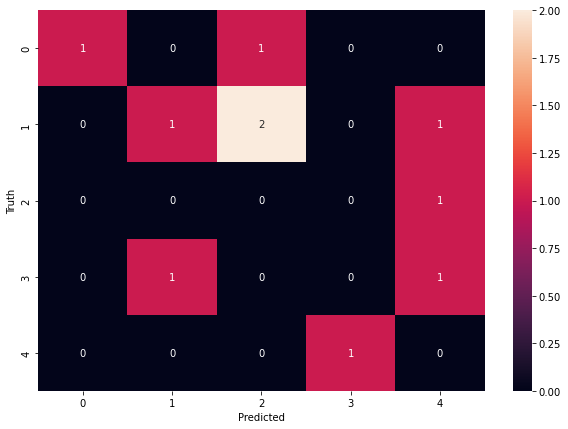

In [48]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [49]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl')


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


['saved_model.pkl']

In [50]:
!pip install joblib


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))